In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [2]:
def findCorrespondingPoints(image1,image2):
    #This variable we use to store the pixel location
    refPt = []
    refPt2 = []

    cv2.namedWindow("image")
    cv2.namedWindow("image2")
    # img = cv2.imread(img_path)
    # img2 = cv2.imread(img2_path)
    img = image1.copy()
    img2 = image2.copy()
    cv2.imshow("image", img)
    cv2.imshow("image2", img2)

    #click event function
    def click_event(event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN:
            # print("image =",x,",",y)
            refPt.append([x,y])
            font = cv2.FONT_HERSHEY_SIMPLEX
            strXY = str(x)+", "+str(y)
            cv2.putText(img, strXY, (x,y), font, 0.5, (255,0,0), 2)
            cv2.imshow("image", img)

    def click_event2(event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN:
            # print("image2 =",x,",",y)
            refPt2.append([x,y])
            font = cv2.FONT_HERSHEY_SIMPLEX
            strXY = str(x)+", "+str(y)
            cv2.putText(img2, strXY, (x,y), font, 0.5, (255,0,0), 2)
            cv2.imshow("image2", img2)

    cv2.setMouseCallback("image", click_event)
    cv2.setMouseCallback("image2", click_event2)

    # cv2.namedWindow("image2")
    # img2 = cv2.imread(r'homography_generation/auditorium.png')
    # cv2.imshow("image2", img2)
    # #calling the mouse click event
    # cv2.setMouseCallback("image2", click_event2)

    cv2.waitKey(0)
    cv2.destroyAllWindows()
    return refPt,refPt2

def findHomographyMatrix(points_source, points_destination):
    # point from camera
    pts_src = np.array(points_source)
    # corresponding points from blueprint
    pts_dst = np.array(points_destination)
    # calculate matrix H
    h, status = cv2.findHomography(pts_src, pts_dst)
    return h

def transformPoint(x,y,h):
    out = cv2.perspectiveTransform(np.array([np.array([[x,y]],dtype='float32')]), h)
    return out[0][0][0],out[0][0][1]

def overlayContour(roiPoints,backgroundImage):
    backgroundImage = backgroundImage.copy()
    contour = [np.array(roiPoints).reshape((-1,1,2)).astype(np.int32)]
    return cv2.drawContours(backgroundImage,contour,0,(255,0,0),4)

def getWarppedRoiPoints(roiPoints,homographyMatrix):
    warppedRoiPoints = []
    for point in roiPoints:
        x,y = transformPoint(point[0],point[1],homographyMatrix)
        warppedRoiPoints.append([int(x),int(y)])
    return warppedRoiPoints

def overlayWarppedImageWithContour(warppedImage,warppedRoiPoint,backgroundImage):
    warppedImage = warppedImage.copy()
    contour = [np.array(warppedRoiPoint).reshape((-1,1,2)).astype(np.int32)]
    # our stencil - some `mask_value` contours on black (zeros) background, 
    # the image has same height and width as `img`, but only 1 color channel
    stencil  = np.zeros(warppedImage.shape[:-1]).astype(np.uint8)
    cv2.fillPoly(stencil, contour, 255)
    # print(warppedImg.shape)
    sel = stencil != 255 # select everything that is not mask_value
    warppedImage[sel] = backgroundImage[sel] # and fill it with fill_color
    # warppedImg[sel] = (0,0,0) # and fill it with fill_color
    return warppedImage

In [3]:
"""
Camera ID
Camera1 -> HC3 
Camera2 -> HC4
Camera3 -> IP2
Camera4 -> IP5
"""

'\nCamera ID\nCamera1 -> HC3 \nCamera2 -> HC4\nCamera3 -> IP2\nCamera4 -> IP5\n'

In [4]:
blueprint = cv2.imread("auditorium/auditorium.png")
cam1 = cv2.imread("auditorium/HC3.png")
cam2 = cv2.imread("auditorium/HC4.png")
cam3 = cv2.imread("auditorium/IP2.png")
cam4 = cv2.imread("auditorium/IP5.png")

blueprint = cv2.cvtColor(blueprint, cv2.COLOR_BGR2RGB)
cam1 = cv2.cvtColor(cam1, cv2.COLOR_BGR2RGB)
cam2 = cv2.cvtColor(cam2, cv2.COLOR_BGR2RGB)
cam3 = cv2.cvtColor(cam3, cv2.COLOR_BGR2RGB)
cam4 = cv2.cvtColor(cam4, cv2.COLOR_BGR2RGB)

In [5]:
# correspondingPointsCam1, correspondingPointsBlueprint1 = findCorrespondingPoints(cam1,blueprint)
correspondingPointsCam1 = [[48, 740],
 [1300, 771],
 [1467, 725],
 [1660, 765],
 [1737, 854],
 [1910, 1030],
 [150, 1071]]
correspondingPointsBlueprint1 = [[272, 613],
 [619, 611],
 [660, 533],
 [698, 612],
 [697, 702],
 [695, 803],
 [530, 848]]

In [6]:
# correspondingPointsCam2, correspondingPointsBlueprint2 = findCorrespondingPoints(cam2,blueprint)
correspondingPointsCam2 = [[15, 666], [1028, 540], [1221, 503], [1352, 528], [1843, 552], [1420, 919]]
correspondingPointsBlueprint2 = [[318, 612], [618, 612], [697, 611], [698, 698], [695, 835], [363, 874]]

In [7]:
# correspondingPointsCam3, correspondingPointsBlueprint3 = findCorrespondingPoints(cam3,blueprint)
correspondingPointsCam3 = [[860, 384], [1887, 379], [1797, 752], [159, 692], [227, 415]]
correspondingPointsBlueprint3 = [[477, 521], [476, 295], [568, 235], [663, 355], [596, 520]]

In [8]:
# correspondingPointsCam4, correspondingPointsBlueprint4 = findCorrespondingPoints(cam4,blueprint)

In [9]:
hCam1 = findHomographyMatrix(correspondingPointsCam1,correspondingPointsBlueprint1)
hCam2 = findHomographyMatrix(correspondingPointsCam2,correspondingPointsBlueprint2)
hCam3 = findHomographyMatrix(correspondingPointsCam3,correspondingPointsBlueprint3)
# hCam4 = findHomographyMatrix(correspondingPointsCam4,correspondingPointsBlueprint4)

In [10]:
# roiPointsCam1,_ =  findCorrespondingPoints(cam1,blueprint)
roiPointsCam1 = [[49, 741],
 [1303, 767],
 [1357, 724],
 [1582, 730],
 [1660, 771],
 [1735, 771],
 [1737, 851],
 [1916, 1035],
 [6, 1075]]

warppedRoiPointsCam1 = getWarppedRoiPoints(roiPointsCam1,hCam1)
 #overlayContour(roiPointsCam1,cam1)

In [11]:
roiPointsCam2 = correspondingPointsCam2
warppedRoiPointsCam2 = getWarppedRoiPoints(roiPointsCam2,hCam2)

In [12]:
roiPointsCam3 = correspondingPointsCam3
warppedRoiPointsCam3 = getWarppedRoiPoints(roiPointsCam3,hCam3)

In [13]:
warppedImageCam1 = cv2.warpPerspective(cam1.copy(),hCam1,blueprint.T.shape[1::])
warppedImageCam2 = cv2.warpPerspective(cam2.copy(),hCam2,blueprint.T.shape[1::])
warppedImageCam3 = cv2.warpPerspective(cam3.copy(),hCam3,blueprint.T.shape[1::])

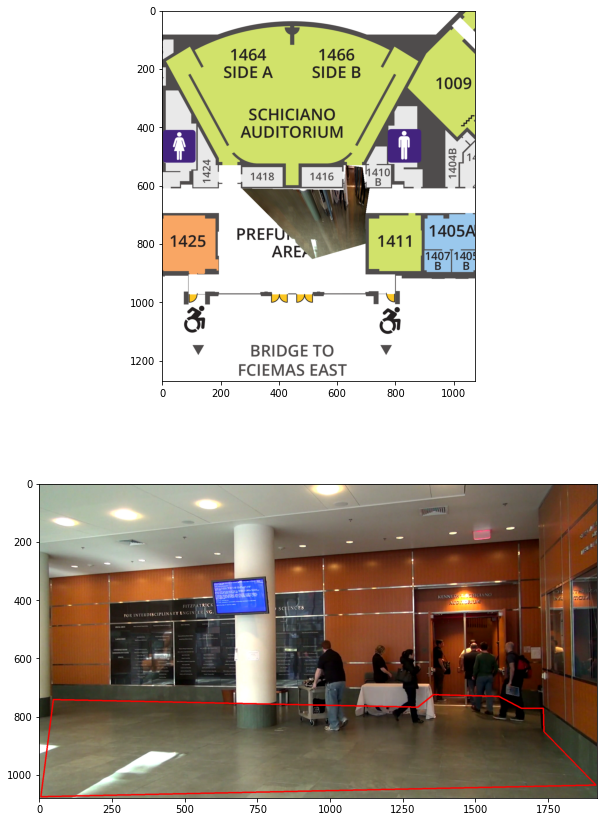

In [14]:
f = plt.figure(figsize=(10,15))
f.add_subplot(2,1, 1)
plt.imshow(overlayWarppedImageWithContour(warppedImageCam1,warppedRoiPointsCam1,blueprint))
f.add_subplot(2,1, 2)
plt.imshow(overlayContour(roiPointsCam1,cam1))
plt.show()

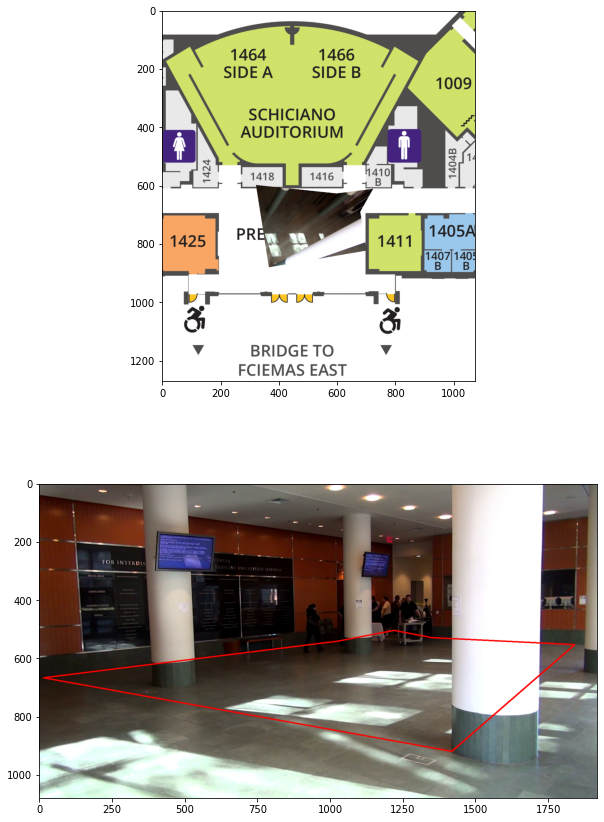

In [15]:
f = plt.figure(figsize=(10,15))
f.add_subplot(2,1, 1)
plt.imshow(overlayWarppedImageWithContour(warppedImageCam2,warppedRoiPointsCam2,blueprint))
f.add_subplot(2,1, 2)
plt.imshow(overlayContour(roiPointsCam2,cam2))
plt.show()

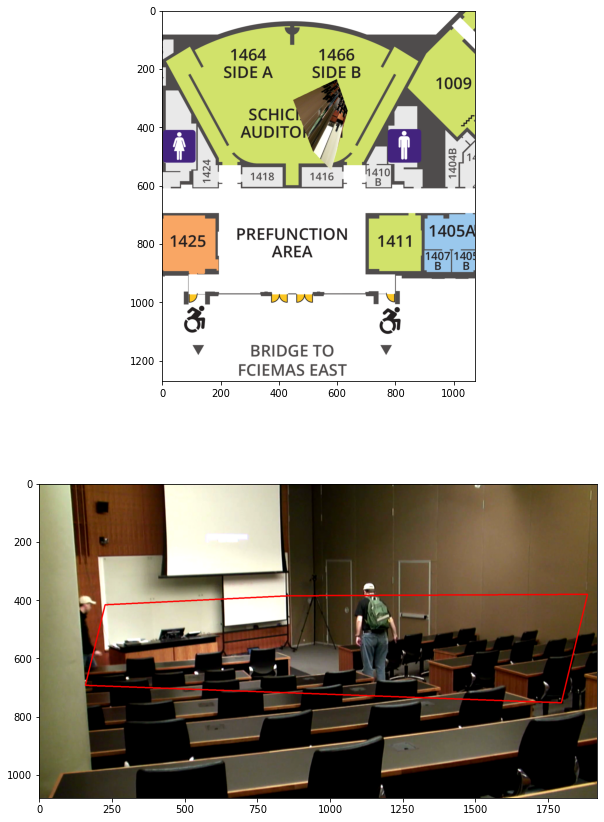

In [16]:
f = plt.figure(figsize=(10,15))
f.add_subplot(2,1, 1)
plt.imshow(overlayWarppedImageWithContour(warppedImageCam3,warppedRoiPointsCam3,blueprint))
f.add_subplot(2,1, 2)
plt.imshow(overlayContour(roiPointsCam3,cam3))
plt.show()

In [17]:
# homography matrix of cam3 is way off due to the difficulty of getting corresponding points between camera pixels and building bluepring. 

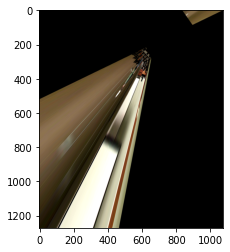

In [18]:
plt.imshow(warppedImageCam3)

In [19]:
import pandas as pd

columns = ['track_id', 'xmin', 'ymin', 'xmax', 'ymax', 'frame_number', 'lost', 'occluded', 'generated', 'label']
data = pd.read_csv('auditorium/view-HC3.txt', sep=" ", names=columns)
point_dict = {}
for track_id in data.track_id.unique():
    df = data.loc[(data.track_id == track_id) & (data.frame_number % 30 == 0),]
    df['xcen'] = df.xmin+(df.xmax-df.xmin)/2
    df['ycen'] = 1080-(df.ymax-df.ymin)
    df['xcen'] = df['xcen'].astype(int)
    df['ycen'] = df['ycen'].astype(int)
    df['xglobal'], df['yglobal'] = zip(*df.apply(lambda x: transformPoint(x.xcen,x.ycen,hCam1),axis=1))
    df['xglobal'] = df['xglobal'].astype(int)
    df['yglobal'] = df['yglobal'].astype(int)
    
    inside = []
    contour = np.array(warppedRoiPointsCam1).reshape((-1,1,2)).astype(np.int32)
    for point in list(zip(df['xglobal'].values,df['yglobal'].values)):
        if cv2.pointPolygonTest(contour,point,False) > 0:
            inside.append(point)
    point_dict[track_id] = inside
    print("ID =",track_id,"\npoints inside contour =",inside)

94), (665, 694), (665, 694), (665, 694), (665, 694), (665, 694), (665, 694), (665, 694), (665, 694), (665, 694), (665, 694), (665, 694), (665, 694), (665, 694), (665, 694), (665, 694), (665, 694), (665, 694), (665, 694), (665, 694), (665, 690), (665, 690), (665, 690), (665, 690), (665, 690), (665, 690), (665, 690), (665, 690), (665, 690), (665, 690), (665, 690), (665, 690), (665, 690), (665, 690), (665, 690), (665, 690), (665, 690), (665, 690), (665, 690), (665, 690), (665, 690), (665, 690), (665, 690), (665, 690), (665, 690)]
ID = 16 
points inside contour = [(662, 712), (649, 708), (635, 699), (621, 698), (604, 688), (586, 678), (569, 676), (548, 664), (524, 650), (503, 647), (474, 632), (483, 616), (521, 626), (565, 639), (600, 634), (630, 641), (652, 648), (659, 675), (661, 695), (663, 705), (663, 705), (663, 705), (663, 705), (663, 705), (663, 705), (663, 705), (663, 705), (663, 705), (663, 705), (663, 705), (663, 705), (663, 705), (663, 705), (663, 705), (663, 705), (663, 705), (

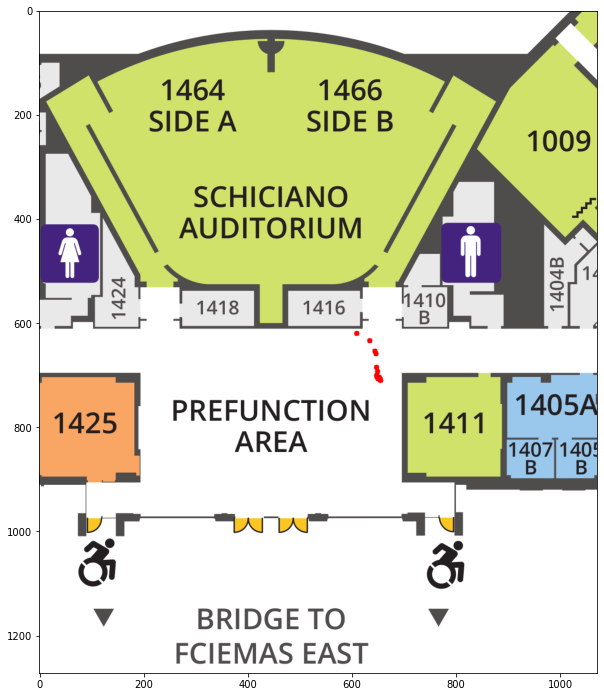

In [20]:
temp = blueprint.copy()
for point in point_dict[18]:
    cv2.circle(temp,point,5,(255,0,0),-1)
plt.figure(figsize=(10,15))
plt.imshow(temp)

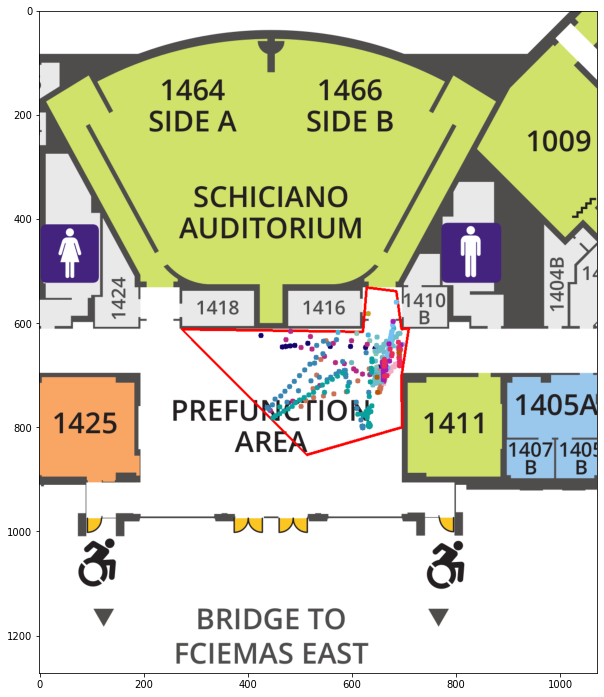

In [21]:
# temp = blueprint.copy()
temp = overlayContour(warppedRoiPointsCam1,blueprint.copy())
for track_id in data.track_id.unique():
    color = (np.random.randint(0,255),np.random.randint(0,255),np.random.randint(0,255))
    for point in point_dict[track_id]:
        cv2.circle(temp,point,5,color,-1)
plt.figure(figsize=(10,15))
plt.imshow(temp)

In [22]:
columns = ['track_id', 'xmin', 'ymin', 'xmax', 'ymax', 'frame_number', 'lost', 'occluded', 'generated', 'label']
data = pd.read_csv('auditorium/view-HC4.txt', sep=" ", names=columns)
point_dict = {}
for track_id in data.track_id.unique():
    df = data.loc[(data.track_id == track_id) & (data.frame_number % 30 == 0),]
    df['xcen'] = df.xmin+(df.xmax-df.xmin)/2
    df['ycen'] = 1080-(df.ymax-df.ymin)
    df['xcen'] = df['xcen'].astype(int)
    df['ycen'] = df['ycen'].astype(int)
    df['xglobal'], df['yglobal'] = zip(*df.apply(lambda x: transformPoint(x.xcen,x.ycen,hCam1),axis=1))
    df['xglobal'] = df['xglobal'].astype(int)
    df['yglobal'] = df['yglobal'].astype(int)
    
    inside = []
    contour = np.array(warppedRoiPointsCam2).reshape((-1,1,2)).astype(np.int32)
    for point in list(zip(df['xglobal'].values,df['yglobal'].values)):
        if cv2.pointPolygonTest(contour,point,False) > 0:
            inside.append(point)
    point_dict[track_id] = inside
    print("ID =",track_id,"\npoints inside contour =",inside)

58), (632, 758), (632, 758), (632, 758), (632, 758), (632, 758), (632, 758), (632, 758), (632, 758), (632, 758), (632, 758), (632, 758), (632, 758), (632, 758), (632, 758), (632, 758), (632, 758), (632, 758), (632, 758), (632, 758), (632, 758), (632, 758), (632, 758), (632, 758), (632, 758), (632, 758), (632, 758), (632, 758), (632, 758), (632, 758), (632, 758), (632, 758), (632, 758), (632, 758), (632, 758), (632, 758), (632, 758), (632, 758), (632, 758), (632, 758), (632, 758), (632, 758), (632, 758), (632, 758), (632, 758), (632, 758), (632, 758), (632, 758), (632, 758), (632, 758), (632, 758), (632, 758), (632, 758), (632, 758), (632, 758), (632, 758), (632, 758), (632, 758), (632, 758), (632, 758), (632, 758), (632, 758), (632, 758), (632, 758), (632, 758), (632, 758), (632, 758), (632, 758), (632, 758), (632, 758), (632, 758), (632, 758), (632, 758), (632, 758), (632, 758), (632, 758), (632, 758), (632, 758), (632, 758), (632, 758), (632, 758), (632, 758), (632, 758), (632, 758),

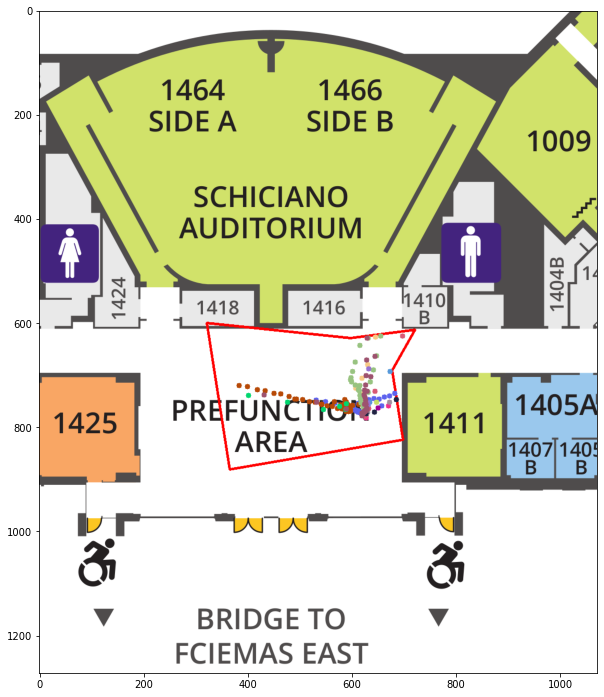

In [23]:
# temp = blueprint.copy()
temp = overlayContour(warppedRoiPointsCam2,blueprint.copy())
for track_id in data.track_id.unique():
    color = (np.random.randint(0,255),np.random.randint(0,255),np.random.randint(0,255))
    for point in point_dict[track_id]:
        cv2.circle(temp,point,5,color,-1)
plt.figure(figsize=(10,15))
plt.imshow(temp)